In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *


In [2]:
# EXPERIMENT PARAMS
from pyfrac.hydrafrac.acquisition import recgeom,rec2das_datatrnsfrm,dasgeom

# LOCATION
from pyfrac.pseudodas.receiveroperators import cubePDoperator
from pyfrac.imaging.kirchhoff import Kirchhoff
from pyfrac.utils.localisationutils import get_max_locs

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage, wiggleplot
from pyfrac.visualisation.eventimages import locimage3d

# SETUP - MODEL, REC GEOM, SOURCES

In [3]:
# Velocity Model
nx, ny, nz = 40, 40, 40
dx, dy, dz = 0.01, 0.01, 0.01
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 5000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

In [4]:
# RECEIVERS
nrperface = 4

# don't need to change below
nxyz = [nx, ny, nz]
dxyz = [dx, dy, dz]
gridded_recs, nr, rec_string = recgeom(nxyz, dxyz, nrperfc_xyz=[nrperface])
print (nr, gridded_recs.shape)

96 (3, 96)


In [5]:
# Microseismic source - SINGULAR
sx, sy, sz = [nx//2, ny//4, nz//2]
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

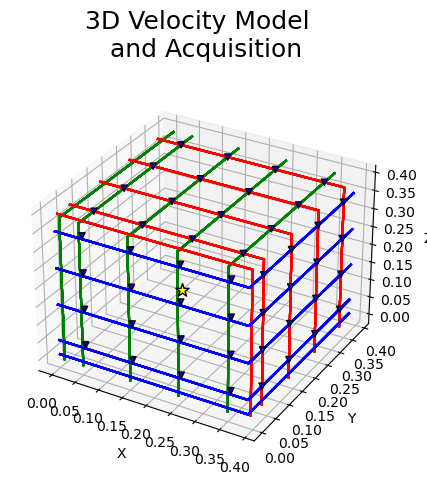

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
r = [0,np.max(x)]
X, Y = np.meshgrid(r, r)
Z0, Z1 = 0*np.ones_like(X), np.max(x)*np.ones_like(X)

# ax.plot_surface(X,Z1,Y, color='grey', alpha=1, zorder=0.3)
# ax.plot_surface(X,Y,Z0,color='grey',  alpha=1, zorder=0.3)
# ax.plot_surface(Z0,X,Y, color='grey', alpha=1, zorder=0.3)
# ax.plot_surface(X,Z0,Y, color='grey', alpha=0.1, zorder=0.3, edgecolor='k')
# ax.plot_surface(X,Y,Z1, color='grey', alpha=0.1, zorder=0.3, edgecolor='k')
# ax.plot_surface(Z1,X,Y, color='grey', alpha=0.1, zorder=0.3, edgecolor='k')


F_zy = np.where(gridded_recs[0]==np.max(gridded_recs[0]))  # constant X
F_zx = np.where(gridded_recs[1]==np.min(gridded_recs[1]))  # constant Y
F_xy = np.where(gridded_recs[2]==np.max(gridded_recs[2]))  # constant Z

# Orientation One
for i,xgr in enumerate(gridded_recs[0]):
    if xgr!=0 and xgr!=np.max(gridded_recs[0]):
        ax.plot3D([xgr,xgr,xgr], 
                  [0,0,np.max(gridded_recs[1])], 
                  [0, np.max(gridded_recs[2]),np.max(gridded_recs[2])], 
                  'green', label='Loop 1')
for i,ygr in enumerate(gridded_recs[1]):
    if ygr!=0 and ygr!=np.max(gridded_recs[1]):
        ax.plot3D([0, np.max(gridded_recs[0]), np.max(gridded_recs[0])], 
                  [ygr,ygr,ygr], 
                  [np.max(gridded_recs[2]), np.max(gridded_recs[2]), 0], 
                  'red', label='Loop 2')
for i,zgr in enumerate(gridded_recs[2]):
    if zgr!=0 and zgr!=np.max(gridded_recs[2]):
        ax.plot3D([0, np.max(gridded_recs[0]), np.max(gridded_recs[0])], 
                  [0, 0, np.max(gridded_recs[1])], 
                  [zgr,zgr,zgr], 
                  'blue', label='Loop 3')
        
for face in [F_zx,F_zy,F_xy]:
    ax.scatter3D(gridded_recs[0][face], gridded_recs[1][face], gridded_recs[2][face],
                alpha=1, color='blue', marker='v', edgecolor='k', label='Point Recs');

ax.scatter3D(sx*dx, sy*dx, sz*dx, alpha=1, color='yellow', marker='*', edgecolor='k', s=100, label='Source');

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.suptitle('3D Velocity Model \n and Acquisition', fontsize=18)
plt.tight_layout()

# MAKE DATA

In [7]:
fs = 40000  # SAMPLING FREQUENCY
fwav = 25000  # WAVELET CENTRAL FREQUENCY
nt = 251  # TIME SAMPLES


In [8]:
fnyq = 0.5 * fs
dt = 1/fs
t = np.arange(nt)*dt
print(max(t))

0.00625


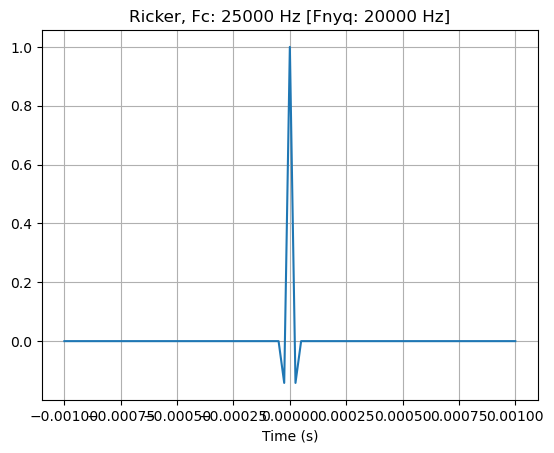

In [9]:
# WAVELET
wav, wavt, wavc = ricker(t[:41], f0=fwav)
plt.plot(wavt, wav,)
plt.xlabel('Time (s)')
plt.title('Ricker, Fc: %i Hz [Fnyq: %i Hz]'%(fwav,fnyq))
plt.grid()

In [10]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=t, 
               srcs=gridded_recs[:, :1], 
               recs=gridded_recs, 
               vel=v0, 
               wav=wav, 
               wavcenter=wavc, 
               mode='analytic', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=1491.737315592169 - u^H(Op^Hv)=1491.73731559216


Text(0.5, 1.0, 'Point Receivers')

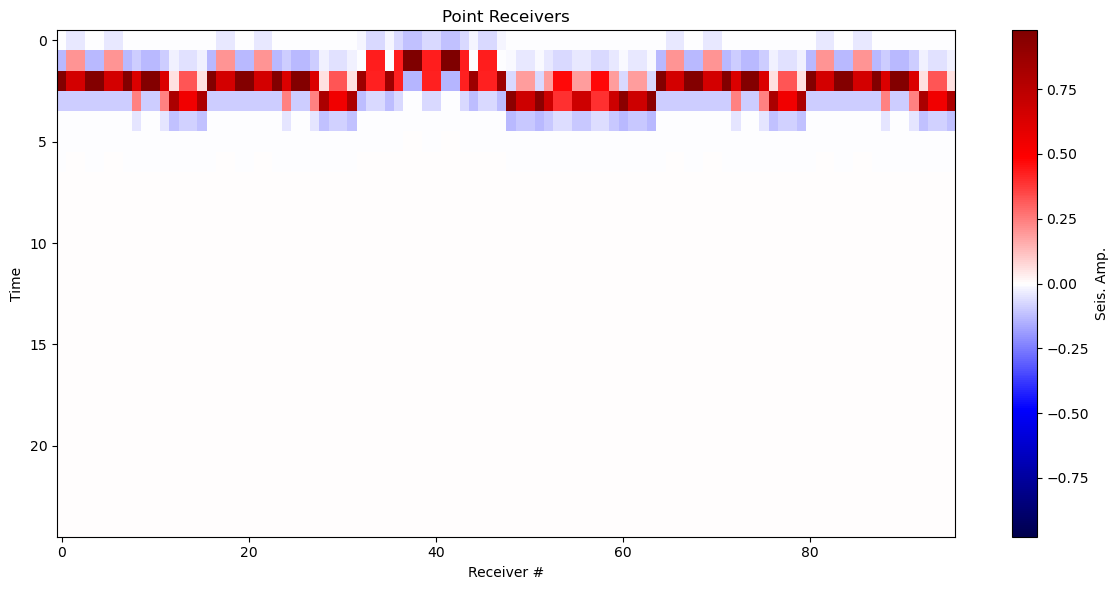

In [11]:
# PERFORM FORWARD (MODEL)
frwddata_1d = Op @ microseismic.flatten().squeeze()
frwddata  = frwddata_1d.reshape(nr,nt)
fig,ax = traceimage(frwddata[:,:25], climQ=99.99)
ax.set_title('Point Receivers')

# POINT REC MIGRATION

True Hypo Center: [20, 10, 20]
Migration-Based Hypo Center: [20.   9.5 20. ]
LSQR Computed Hypo Center: [20.  10.5 20. ]


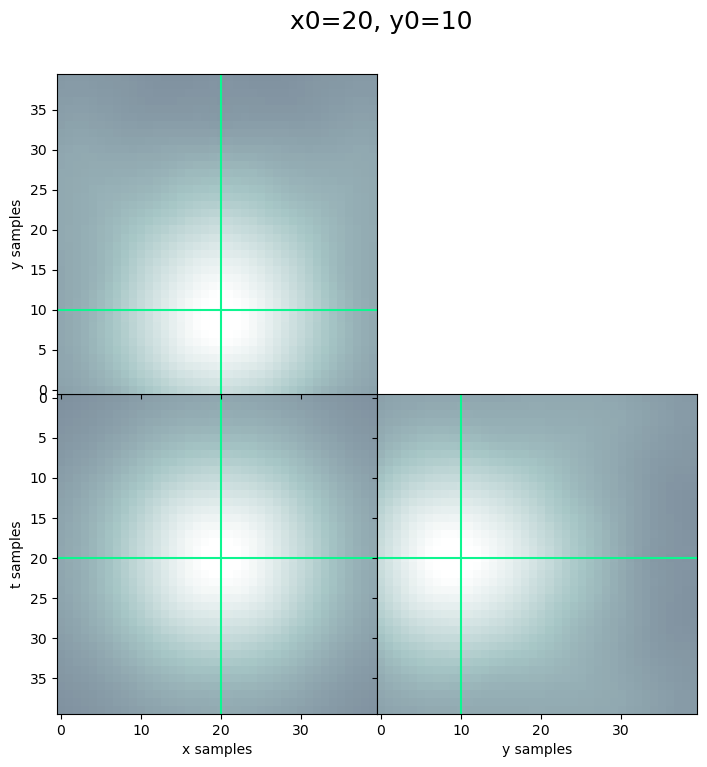

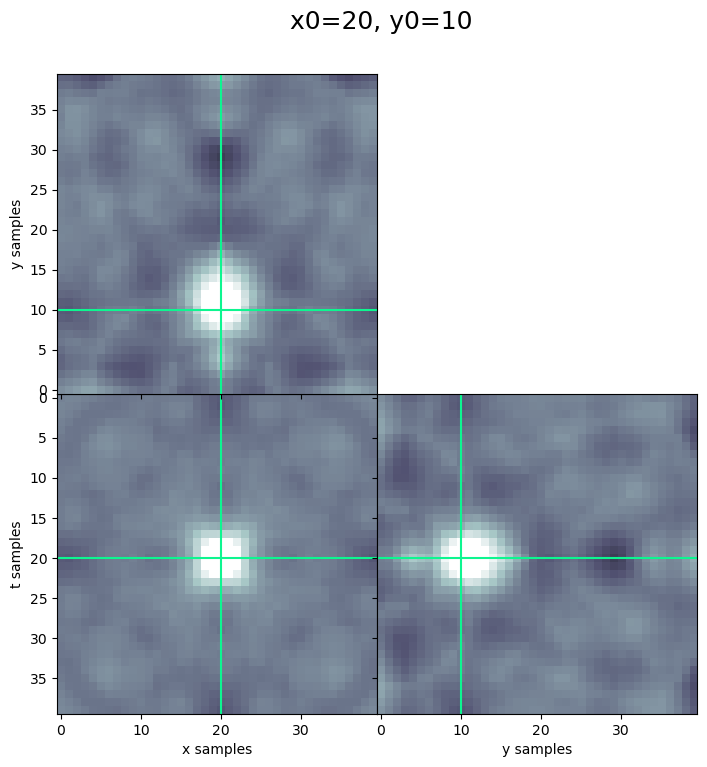

In [12]:
print('True Hypo Center:', [sx,sy,sz])

migrated = (Op.H @ frwddata).reshape(nx,ny,nz)
hc, hcs =  get_max_locs(migrated, n_max=10, rem_edge=False)
print('Migration-Based Hypo Center:',hc.flatten())
fig,axs = locimage3d(migrated,sx,sy)

inv = (lsqr(Op, frwddata.ravel(), iter_lim=100, show=False)[0]).reshape(nx,ny,nz)
hc, hcs =  get_max_locs(inv, n_max=10, rem_edge=False)
print('LSQR Computed Hypo Center:',hc.flatten())
fig,axs = locimage3d(inv,sx,sy)

# PSEUDO-DAS

Text(0.5, 1.0, 'Pseudo-DAS')

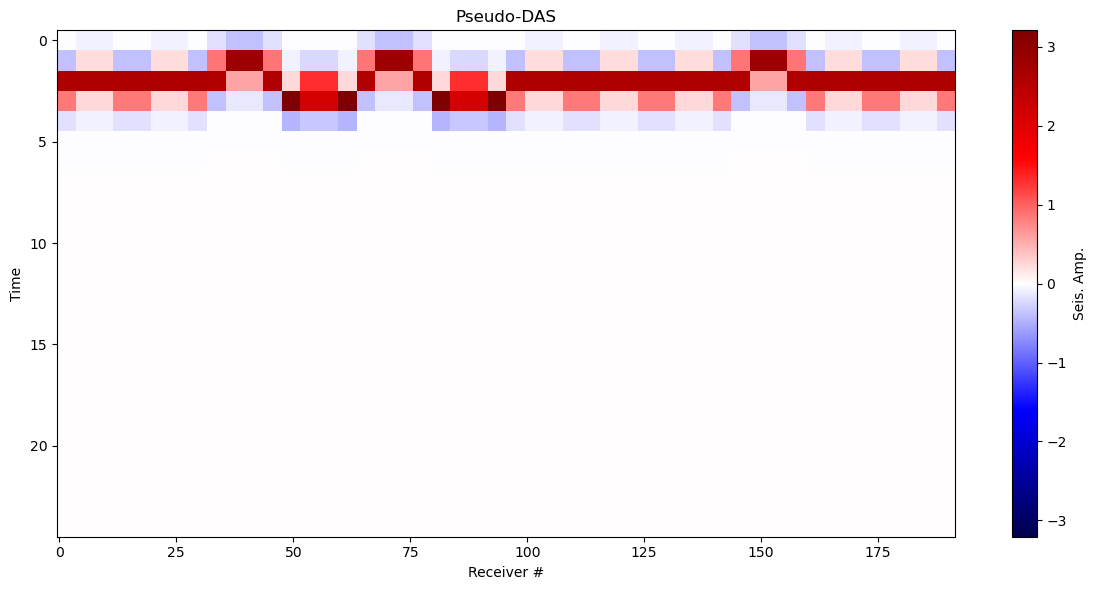

In [13]:
nr_x = nrperface
pdas_recs = dasgeom(nxyz, dxyz, nrperfc_xyz=[nrperface])
pdas_data = rec2das_datatrnsfrm(frwddata, [nr_x, nr_x, nr_x], nt)
fig,ax = traceimage(pdas_data[:,:25], climQ=99.99, cmap='seismic')
ax.set_title('Pseudo-DAS')

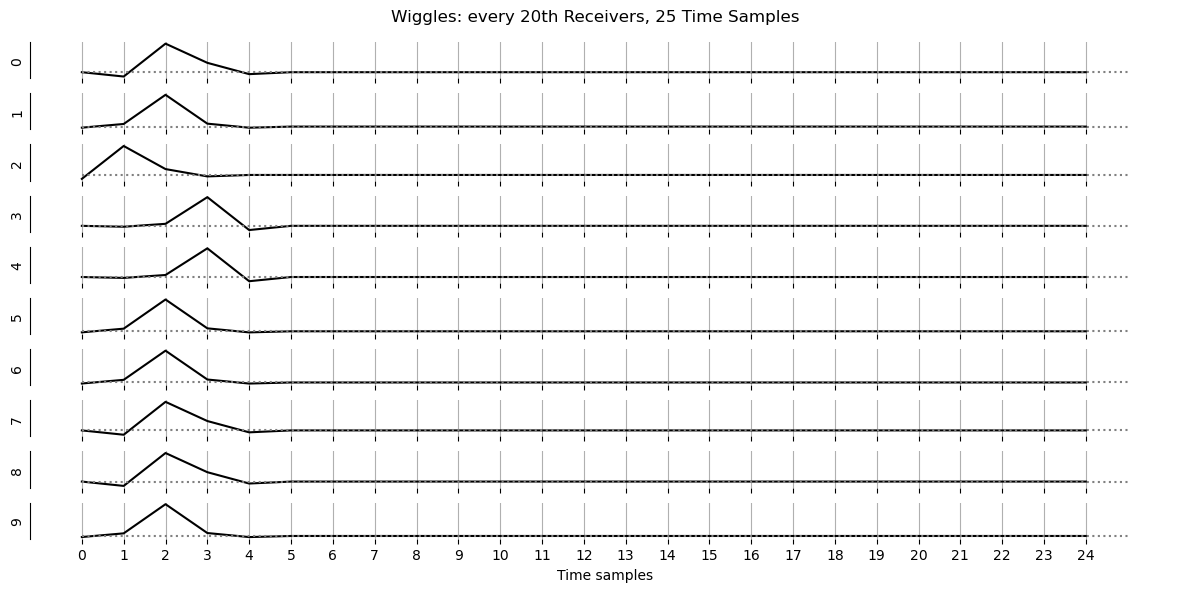

In [14]:
fig, axs = wiggleplot(pdas_data[::20,:25], norm_indiv=True, figsize=[12, 6]);
fig.suptitle('Wiggles: every 20th Receivers, 25 Time Samples')
fig.tight_layout()

TRANSFORMED -> MIGRATE
True Hypo Center: [20, 10, 20]
Migration-Based Hypo Center: [20.4 11.5 20. ]
LSQR Computed Hypo Center: [ 0.2 38.4 11.8]
FISTA Computed Hypo Center: [21.5 11.7 20.1]


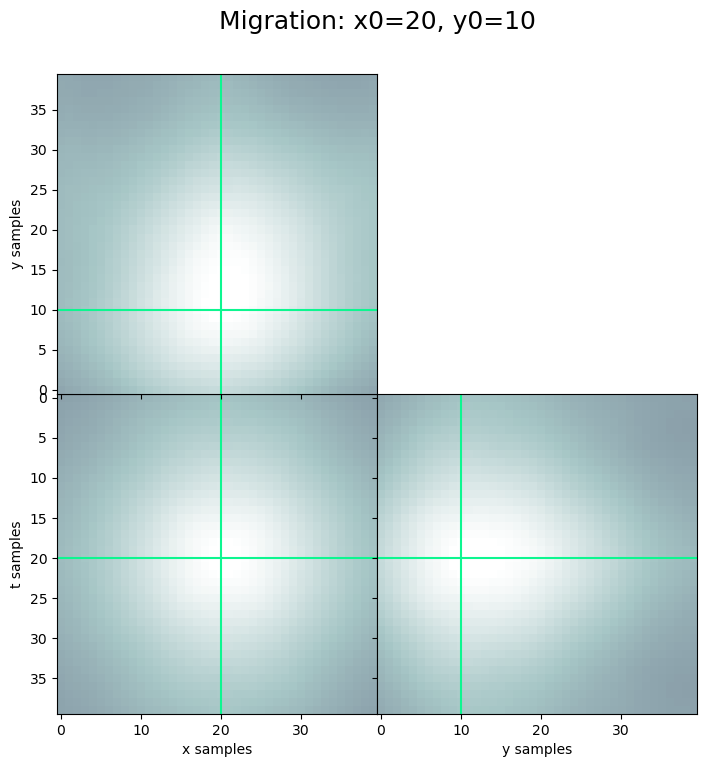

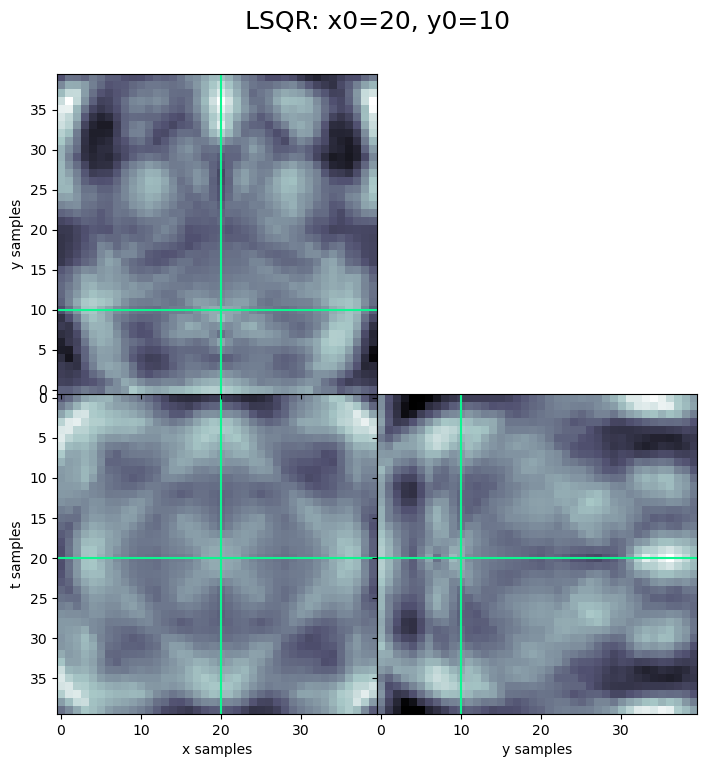

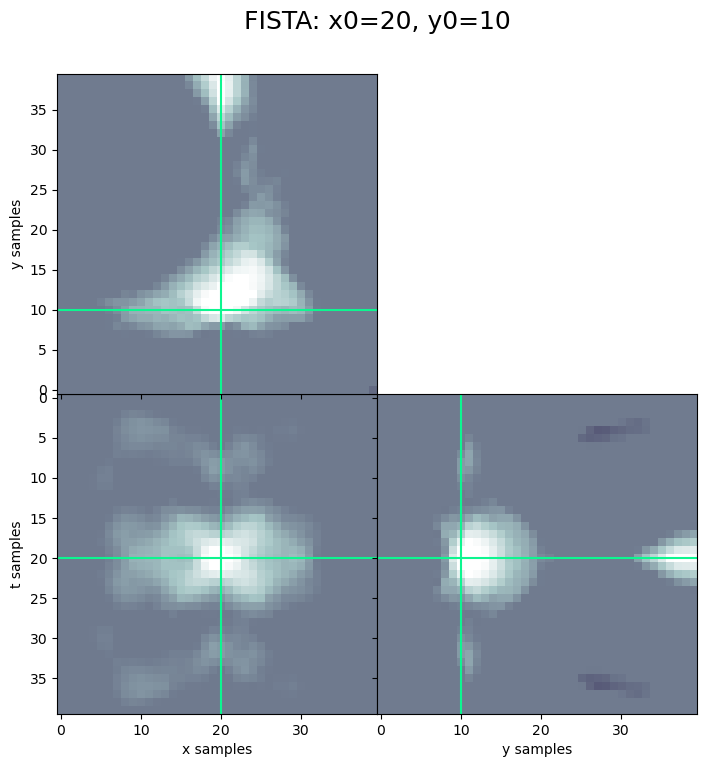

In [15]:
# TRANSFORMED -> MIGRATE
print('TRANSFORMED -> MIGRATE')
SumStackOp = cubePDoperator(nr_x, nt)
pdasFrwdOp = SumStackOp * Op

print('True Hypo Center:', [sx,sy,sz])

pdas_migration = (pdasFrwdOp.H @ pdas_data.ravel()).reshape(nx,ny,nz)
hc, hcs =  get_max_locs(pdas_migration, n_max=10, rem_edge=False)
print('Migration-Based Hypo Center:',hc.flatten())
fig,axs = locimage3d(pdas_migration,sx,sy,pretitle='Migration:')


pdas_lsqr = lsqr(pdasFrwdOp, pdas_data.flatten(), iter_lim=100, show=False)[0].reshape(nx,ny,nz)
hc, hcs =  get_max_locs(pdas_lsqr, n_max=10, rem_edge=False)
print('LSQR Computed Hypo Center:',hc.flatten())
fig,axs = locimage3d(pdas_lsqr,sx,sy,pretitle='LSQR:')

with pylops.disabled_ndarray_multiplication():
    pdas_fista = fista(pdasFrwdOp, pdas_data.flatten(), niter=100, eps=1e2, show=False)[0].reshape(nx,ny,nz)
hc, hcs =  get_max_locs(pdas_fista, n_max=10, rem_edge=False)
print('FISTA Computed Hypo Center:',hc.flatten())
fig,axs = locimage3d(pdas_fista,sx,sy,pretitle='FISTA:')

In [16]:
hc, hcs =  get_max_locs(pdas_fista, n_max=10, rem_edge=True, edgebuf=3)
print(hc)


[21.5 11.7 20.1]
